# AAC Article 

## Initialize Kusto connection in Python Environment

Running the queries in this analysis requires package [Kqlmagic](https://github.com/microsoft/jupyter-Kqlmagic). Following commands will install and load the pacage. There's a Kusto connection creation and test command. When you run the command, you will see a link of https://microsoft.com/devicelogin popped up in the output. Please do click that and input the code. This will grant Kusto permission to your environment of this jupyter note. If you run all the commands in one session, you just have to authorize once.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


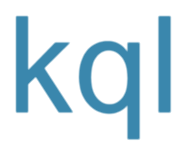

In [2]:
%load_ext Kqlmagic

In [1]:
!pip install Kqlmagic --no-cache-dir --upgrade

     |████████████████████████████████| 143kB 1.3MB/s eta 0:00:01
  Found existing installation: Kqlmagic 0.1.107.post1
    Uninstalling Kqlmagic-0.1.107.post1:
      Successfully uninstalled Kqlmagic-0.1.107.post1


You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
kcsb = KustoConnectionStringBuilder.with_aad_device_authentication("https://cgadataout.kusto.windows.net")
kc = KustoClient(kcsb)

query= """database("CustomerTouchPoint").PageView
| where Site == 'docs.microsoft.com'
| count"""
response = kc.execute("DevRelWorkArea", query)
print(response.primary_results[0][0])

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FB2HN6AKL to authenticate.
['5606352639']


In [24]:
# architecture-center by page types
query= """let aac = database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-02-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore();
aac
| where RepoName == 'architecture-center'
| project TopicKey, PageViews, PageType, PrimaryKPIScore
| join kind=inner(
    aac
    | summarize hint.strategy = shuffle 25PctlL1 = percentile(PrimaryKPIScore, 25) by PageType
) on PageType
| summarize
    pageviews_overperforming = sumif(PageViews, PrimaryKPIScore>=25PctlL1),
    pageviews_underperforming = sumif(PageViews, PrimaryKPIScore<25PctlL1),
    pageviews_total = sum(PageViews),
    topics_overperforming = dcountif(TopicKey,PrimaryKPIScore>=25PctlL1,2),
    topics_underperforming = dcountif(TopicKey,PrimaryKPIScore<25PctlL1,2),
    topics_total = dcount(TopicKey,2)
    by PageType
| extend rate_pageviews_overperforming = todouble(pageviews_overperforming)/(pageviews_overperforming+pageviews_underperforming)
| extend rate_topics_overperforming = todouble(topics_overperforming)/(topics_overperforming+topics_underperforming)"""
response = kc.execute("DevRelWorkArea", query)
ptype = []
pvhighperf = []
pvlowperf = []
pvtotal = []
tphighperf = []
tplowperf = []
tptotal=[]
ratepvhighperf = []
ratetphighperf = []
for row in response.primary_results[0]:
    ptype.append(row[0])
    pvhighperf.append(row[1])
    pvlowperf.append(row[2])
    pvtotal.append(row[3])
    tphighperf.append(row[4])
    tplowperf.append(row[5])
    tptotal.append(row[6])
    ratepvhighperf.append(row[7])
    ratetphighperf.append(row[8])
print("aac repo page type statistic loaded")

aac repo page type statistic loaded


In [13]:
print(ptype)
print(pvhighperf)
print(pvlowperf)

['Reference', 'ExampleScenario', 'HubLanding', 'DesignGuide', 'ReferenceArchitecture', 'Overview']
[3922.0, 15764.0, 106261.0, 131511.0, 143110.0, 3195.0]
[0.0, 6713.0, 13.0, 48762.0, 149485.0, 4054.0]


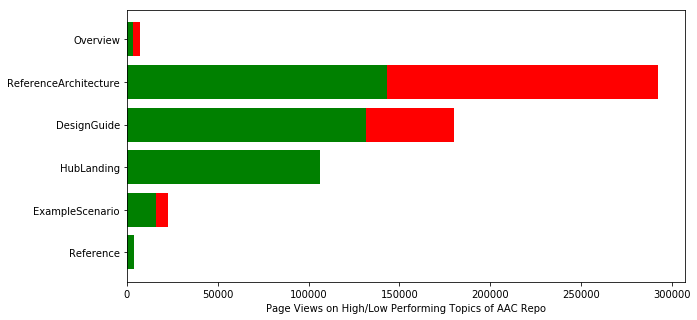

In [25]:
y_pos = np.arange(len(ptype))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.barh(y_pos, pvtotal, color='r',align='center')
ax.barh(y_pos, pvhighperf, color='g',align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ptype)
ax.set_xlabel('Page Views on High/Low Performing Topics of AAC Repo')
plt.show()
#df = pd.DataFrame({"PageType": ptype,
#                  "% of Page Views on High Performing Topics": ratepvhighperf})
#df = df[::-1]
#print(df)

In [26]:
# RA topics
query= """let aac = database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-02-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore();
aac
| where RepoName == 'architecture-center'
| where PageType == 'ReferenceArchitecture'
| project TopicKey, PageViews, PrimaryKPIScore"""
response = kc.execute("DevRelWorkArea", query)
tpkey=[]
tppv=[]
tpscore=[]
for row in response.primary_results[0]:
    tpkey.append(row[0])
    tppv.append(row[1])
    tpscore.append(row[2])
print("aac repo page type statistic loaded")

# RA 25 percenticle
query= """database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-02-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| where PageType == 'ReferenceArchitecture'
| summarize hint.strategy = shuffle 25PctlL1 = percentile(PrimaryKPIScore, 25)"""
response = kc.execute("DevRelWorkArea", query)
rascore_25pctl=0.0
for row in response.primary_results[0]:
    rascore_25pctl = row[0]
print(rascore_25pctl)

aac repo page type statistic loaded
0.2535971223021583


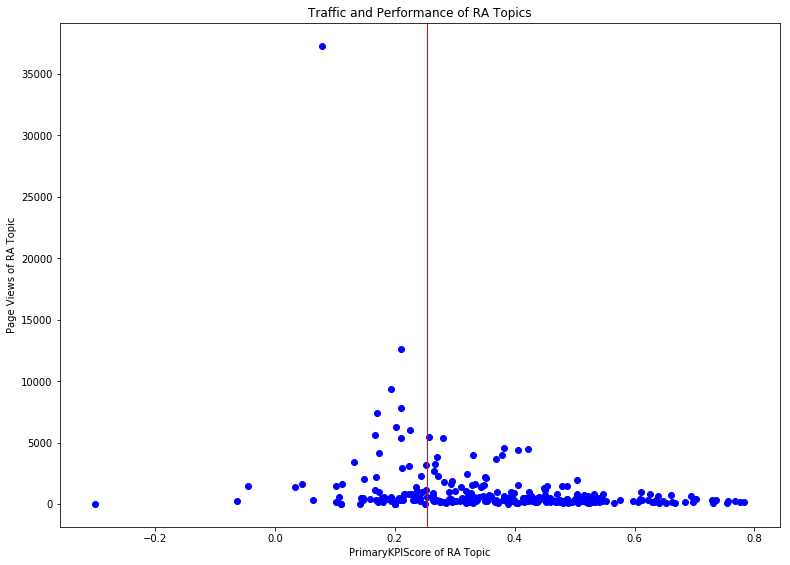

In [28]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(tpscore, tppv, color='b')
ax.set_xlabel('PrimaryKPIScore of RA Topic')
ax.set_ylabel('Page Views of RA Topic')
ax.set_title('Traffic and Performance of RA Topics')
plt.axvline(x=rascore_25pctl, color='r', linewidth=1)
plt.show()

In [3]:
# CTR+Bounce Rate for RA topics
query= """let startDate = datetime(2020-02-01);
let endDate = datetime(2020-03-01);
let locale = "en-us";
database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| where Locale == Locale
| summarize hint.strategy = shuffle
    PageViews = dcount(PageViewId,2),
    Bounces=dcountif(PageViewId, IsBounce, 2),
    ClickThroughs = dcountif(PageViewId, LinkClickEvents>0, 2)
    by TopicKey
| join kind=leftouter (
database("DevRelWorkArea").GetTopics(locale)
) on TopicKey
| where RepoName == 'architecture-center'
| where PageType == 'ReferenceArchitecture'
| extend isTarget = TopicKey == '4f3b9f17-3e21-2b2b-6089-b4fbd4387cf9'
| extend
    NonBounceRate = 1-(Bounces/todouble(PageViews)),
    ClickThroughRate = ClickThroughs/todouble(PageViews)
| project TopicKey, isTarget, ClickThroughRate, NonBounceRate"""
response = kc.execute("DevRelWorkArea", query)
rakey=[]
istg=[]
ctr=[]
nbr=[]
for row in response.primary_results[0]:
    rakey.append(row[0])
    istg.append(row[1])
    ctr.append(row[2])
    nbr.append(row[3])
print("ra topics loaded")

ra topics loaded


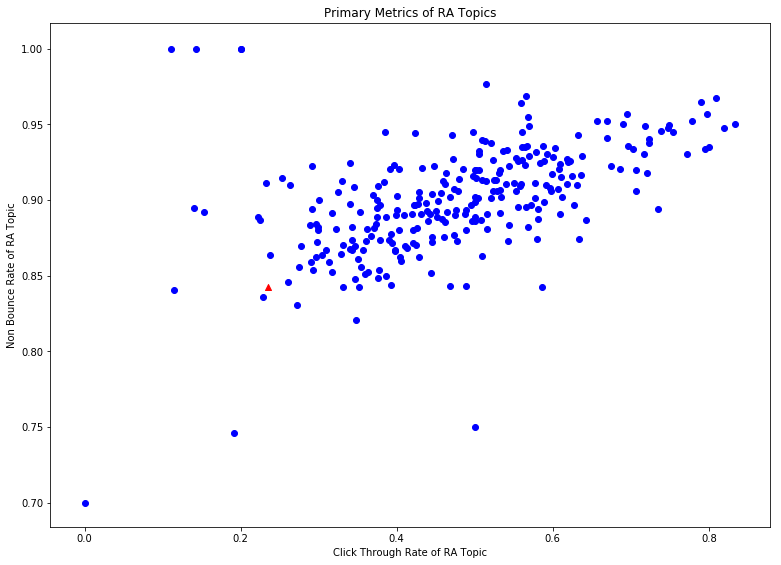

In [10]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_axes([0,0,1,1])
for i in range(len(rakey)):
    if istg[i]==1:
        ax.scatter(ctr[i], nbr[i], c='r', marker="^")
    else:
        ax.scatter(ctr[i], nbr[i], c='b')
ax.set_xlabel('Click Through Rate of RA Topic')
ax.set_ylabel('Non Bounce Rate of RA Topic')
ax.set_title('Primary Metrics of RA Topics')
plt.show()

In [11]:
# aws metrics by referrer type
query= """let startDate = datetime(2020-02-01);
let endDate = datetime(2020-03-01);
let locale = "en-us";
database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| where Locale == Locale
| where TopicKey == '4f3b9f17-3e21-2b2b-6089-b4fbd4387cf9'
| where ReferrerType != 'Paid Search'
| summarize hint.strategy = shuffle
    PageViews = dcount(PageViewId,2),
    Bounces=dcountif(PageViewId, IsBounce, 2),
    ClickThroughs = dcountif(PageViewId, LinkClickEvents>0, 2)
    by ReferrerType
| extend
    NonBounceRate = 1-(Bounces/todouble(PageViews)),
    ClickThroughRate = ClickThroughs/todouble(PageViews)
| project ReferrerType, PageViews, ClickThroughRate, NonBounceRate"""
response = kc.execute("DevRelWorkArea", query)
reftype=[]
refpv=[]
refctr=[]
refnbr=[]
for row in response.primary_results[0]:
    reftype.append(row[0])
    refpv.append(row[1])
    refctr.append(row[2])
    refnbr.append(row[3])
print("aws metrics by referrer types loaded")

aws metrics by referrer types loaded


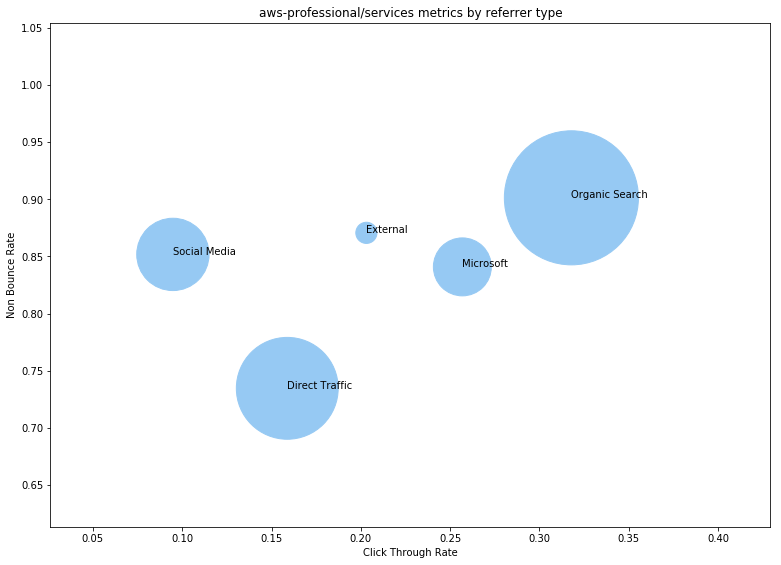

In [15]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(refctr, refnbr, color='#96C9F3', s=refpv)
for i, t in enumerate(reftype):
    ax.annotate(t, (refctr[i], refnbr[i]))
ax.set_xlabel('Click Through Rate')
ax.set_ylabel('Non Bounce Rate')
ax.set_title('aws-professional/services metrics by referrer type')
plt.show()

In [7]:
query= """let startDate = datetime(2020-02-01);
let endDate = datetime(2020-03-01);
let locale = "en-us";
database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| where Locale == Locale
| where TopicKey == '4f3b9f17-3e21-2b2b-6089-b4fbd4387cf9'
| where ReferrerType != 'Paid Search'
| summarize hint.strategy = shuffle
    PageViews = dcount(PageViewId,2),
    Bounces=dcountif(PageViewId, IsBounce, 2),
    ClickThroughs = dcountif(PageViewId, LinkClickEvents>0, 2),
    MedianPageViewTime = percentile(ActivePageViewLength,50)
    by TopicKey, ReferrerType
| join kind=leftouter (
database("DevRelWorkArea").GetTopics(locale)
) on TopicKey
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = 0.0,
    ExitRate = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead), //not use in this PageType
    LearnModuleCompletion = 0, //not use in this PageType
    LearnUnitCompletion = 0, //not use in this PageType
    LearnModuleCompletionRate = 0.0, //not use in this PageType
    LearnUnitCompletionRate = 0.0 //not use in this PageType
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project ReferrerType = strcat(ReferrerType," (",tostring(round(PrimaryKPIScoreL2,3)),")"), PageViews, PrimaryKPIScoreL2"""
response = kc.execute("DevRelWorkArea", query)
rf = []
pv = []
scoreL2 = []
for row in response.primary_results[0]:
    rf.append(row[0])
    pv.append(row[1])
    scoreL2.append(row[2])
print("article scores loaded")

KeyboardInterrupt: 

In [ ]:
print(scoreL2)

df = pd.DataFrame({"Referrer": rf,
                  "MedianPrimaryKPIScoreL2": scoreL2})
print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

print(df)

In [ ]:
query= """database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-02-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| where PageType == 'ReferenceArchitecture'
| summarize hint.strategy = shuffle (10PctlL1,25PctlL1,50PctlL1,75PctlL1,90PctlL1) = percentiles(PrimaryKPIScore, 10, 25, 50, 75, 90) by PageType"""
response = kc.execute("DevRelWorkArea", query)
pctl_10 = 0.0
pctl_25 = 0.0
pctl_50 = 0.0
pctl_75 = 0.0
pctl_90 = 0.0
for row in response.primary_results[0]:
    pctl_10 = row[0]
    pctl_25 = row[1]
    pctl_50 = row[2]
    pctl_75 = row[3]
    pctl_90 = row[4]
print("L1 scores loaded")

In [ ]:
df = pd.DataFrame({"Referrer": rf,
                  "PrimaryKPIScoreL2": scoreL2})
print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

## Radar Chart
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.173,0.254], ["RA Page Type 10pctl (0.173)","RA Page Type 25pctl (0.254)"], color="red", size=10)
plt.ylim(-0.2,0.35)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="PrimaryKPIScoreL2")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
# values=df.loc[1].drop('index').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL1")
# ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

We see that most of the page types have the median value of PrimaryKPIScoreL2 (performance from site search) better than the median value of PrimaryKPIScoreL1 (performance overall) except "ReferenceArchitecture" and "Unknown" types. There have another concept **25 Percentile of PrimaryKPIScore** in content performance model which is used for identifying over-performing topics vs under-performance topics. Let's see how the radar chart becomes when comparing the 25 percentile values between L2 and L1.

In [ ]:
df = pd.DataFrame({"PageType": ptype,
                  "25PctlPrimaryKPIScoreL2": oL2,
                  "25PctlPrimaryKPIScoreL1": oL1})
print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

## Radar Chart
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.5], ["-0.8","-0.6","-0.4","-0.2","0","0.5"], color="black", size=7)
plt.ylim(-1,1)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL2")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL1")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

It becomes more interesting that the 25 percentile chart shows a different result. Most of the page types have the 25 percentile values of PrimaryKPIScoreL1 larger than what of L2. Putting median value comparison and 25 percentile value comparison together, **an hypothesis is that the PrimaryKPIScoreL2 values are not normally distributed**. Let's look at the scores distribution of "Article" type.

In [ ]:
# get PrimaryKPIScoreL2 by topics from site search
query= """let startDate = datetime(2020-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType == 'Article'
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, PrimaryKPIScoreL2, PageViews"""
response = kc.execute("DevRelWorkArea", query)
tpL2 = []
scoreL2 = []
pvL2 = []
for row in response.primary_results[0]:
    tpL2.append(row[0])
    scoreL2.append(row[1])
    pvL2.append(row[2])
print("data loaded")

In [ ]:
n_bins = 20
n_scoreL2 = []
for (i, item) in enumerate(scoreL2):
    if item > 2:
        n_scoreL2.append(2)
    else:
        n_scoreL2.append(item)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))
axs[0].hist(scoreL2, bins=n_bins)
axs[0].set_xlabel('PrimaryKPIScoreL2')
axs[1].hist(n_scoreL2, bins=n_bins)
axs[1].set_xlabel('PrimaryKPIScoreL2 with outliers set to 2')

In the left chart, it shows the distribution of the actual PrimaryKPIScoreL2 values. The right chart shows the distribution of PrimaryKPIScoreL2 values with outliers fixed. There are several topics (viewed from site search) having extremely large DwellTime which made the performance score be a very big value. I set the score of these outliers to 2 which can get a more readable histogram.

In [ ]:
# get PrimaryKPIScoreL1 by topics
query= """database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-01-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| where PageType == 'Article'
| project TopicKey, PrimaryKPIScore, PageViews"""
response = kc.execute("DevRelWorkArea", query)
tpL1 = []
scoreL1 = []
pvL1 = []
for row in response.primary_results[0]:
    tpL1.append(row[0])
    scoreL1.append(row[1])
    pvL1.append(row[2])

In [ ]:
n_bins = 20
n_scoreL1 = []
for (i, item) in enumerate(scoreL1):
    if item > 2:
        n_scoreL1.append(2)
    else:
        n_scoreL1.append(item)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))
axs[0].hist(scoreL1, bins=n_bins)
axs[0].set_xlabel('PrimaryKPIScoreL1')
axs[1].hist(n_scoreL1, bins=n_bins)
axs[1].set_xlabel('PrimaryKPIScoreL1 with outliers set to 2')

Since we get idea of how PrimaryKPIScoreL2 is measured. Also, we have compared the median values by page type between PrimaryKPIScoreL2 and PrimaryKPIScoreL1. Then another question is that because the PrimaryKPIScoreL2 is calculated at topic level, to understand better the performance of traffic, we need to look at the performance score and traffic (page views) together.

So, let's define: **If the PrimaryKPIScoreL2 > 25 percentile value of PrimaryKPIScoreL1, then we say the topic from site search (its traffic from site search) is high performing. Otherwise we say the topic from site search is low performing.**

In [ ]:
# reference to https://www.tutorialspoint.com/matplotlib/matplotlib_scatter_plot.htm
fig=plt.figure(figsize=(10,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(n_scoreL2, pvL2, color='b')
ax.set_xlabel('PrimaryKPIScoreL2 on Topic')
ax.set_ylabel('Page Views on Topic')
ax.set_title('Traffic and Performance of "Article" topics From Site Search')
plt.axvline(x=-0.806845, color='r', linewidth=1)
plt.show()

From the scatter chart, we may see that more than 85% of the points are at right side of the red line. The red vertical line is 25 percentile value of PrimaryKPIScoreL1. The y axis is the page views on each topic. We may see most of the pages having page views less than 100. There are several pages having high traffic, all of them seems be high performing.

Furthermore, we can sum the page views of the high performing topics from site search, and we sum the page views of the low performing topics from site search. Thus, we are able to know the percentage of page views on high performing topics. Following is the % of page views on high performing topics per page type (LearnModule, LearnUnit not included).

In [ ]:
# get PrimaryKPIScoreL1 by topics
query= """let startDate = datetime(2020-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType !in ('LearnModule','LearnUnit')
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, PrimaryKPIScoreL2, PageViews, PageType
| join kind=leftouter (
database("DevRelWorkArea").GetL1PrimaryKPIScore(startDate, "en-us")
) on PageType
| summarize
    pv_highperf = sumif(PageViews, PrimaryKPIScoreL2 > ThresholdPrimaryKPIScore_L1),
    pv_lowperf = sumif(PageViews, PrimaryKPIScoreL2 <= ThresholdPrimaryKPIScore_L1)
    by PageType
| extend pv_total = pv_highperf+pv_lowperf
| extend rate_highperf = round(pv_highperf/todouble(pv_total),3)
| sort by PageType desc"""
response = kc.execute("DevRelWorkArea", query)
ptype = []
pvhighperf = []
pvlowperf = []
pvtotal = []
ratehighperf = []
for row in response.primary_results[0]:
    ptype.append(row[0])
    pvhighperf.append(row[1])
    pvlowperf.append(row[2])
    pvtotal.append(row[3])
    ratehighperf.append(row[4])
print("data loaded")

In [ ]:
# reference to https://stackoverflow.com/questions/21397549/stack-bar-plot-in-matplotlib-and-add-label-to-each-section-and-suggestions
y_pos = np.arange(len(ptype))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.barh(y_pos, pvhighperf,color='g',align='center')
ax.barh(y_pos, pvlowperf,color='r',align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ptype)
ax.set_xlabel('Page Views on High/Low Performing Topics (From Site Search)')
plt.show()

df = pd.DataFrame({"PageType": ptype,
                  "% of Page Views on High Performing Topics": ratehighperf})
df = df[::-1]
print(df)

From that table, we can see "Reference", "Conceptual", "Article" types have high page views traffic. Their % of page views on high performing topics (from site search) are around 85%. "Unknown" type also has relatively high page view traffic comparing to the rest, its % is low, only 68.9%. We may have interests to see what are the low performing pages referred from site search, especially the ones having relatively high page views traffic. Following lists the top 20 low performing Reference topics from site search, ranked by their page views from site search.

In [ ]:
# get PrimaryKPIScoreL2 by topics
query= """let startDate = datetime(2020-01-01);
let endDate = startofmonth(startDate,1);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50),
    TargetURL = max(TargetURL)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType == 'Reference'
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, TargetURL, PrimaryKPIScoreL2, PageViews, PageType
| join kind=leftouter (
database("DevRelWorkArea").GetL1PrimaryKPIScore(startDate, "en-us")
) on PageType
| where PrimaryKPIScoreL2 <= ThresholdPrimaryKPIScore_L1
| top 10 by PageViews desc
| project TargetURL, PageType, PageViews, PrimaryKPIScoreL2, 25PercentilePrimaryKPIScoreL1 = ThresholdPrimaryKPIScore_L1
| extend L2L1Delta = PrimaryKPIScoreL2 - 25PercentilePrimaryKPIScoreL1"""
response = kc.execute("DevRelWorkArea", query)
url = []
ptype = []
pv = []
L2 = []
oL1 = []
delta = []
for row in response.primary_results[0]:
    url.append(row[0])
    ptype.append(row[1])
    pv.append(row[2])
    L2.append(row[3])
    oL1.append(row[4])
    delta.append(row[5])
df = pd.DataFrame({"URL": url,
                   "PageType": ptype,
                   "PageViews": pv,
                   "L2": L2,
                   "25 Pctl L1": oL1,
                   "Delta": delta})
# print(df)
from IPython.display import display, HTML
display(HTML(df.to_html()))

If we want to see what search terms make one certain topic become low performing, we may have the breakdown by search terms. For each search term and target topic, we may also calculate out one score (let's call it `PrimaryKPIScoreL3`) which measures the performance on the page views to the topic from that search term. Take a the top one low performing unknown type topic "https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql" as an example.

In [ ]:
# get PrimaryKPIScoreL3 by search terms
query= """let startDate = datetime(2020-01-01);
let endDate = startofmonth(startDate,1);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| where TargetURL == "https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql"
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50),
    TargetURL = max(TargetURL)
    by TargetTopicKey, TargetSearchTerm
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL3 = PrimaryKPIScore
| project TargetSearchTerm, TargetURL, PrimaryKPIScoreL3, PageViews"""
response = kc.execute("DevRelWorkArea", query)
term = []
url = []
L3 = []
pv = []
for row in response.primary_results[0]:
    term.append(row[0])
    url.append(row[1])
    L3.append(row[2])
    pv.append(row[3])
df = pd.DataFrame({"SearchTerms": term,
                   "URL": url,
                   "PageViews": pv,
                   "L3": L3,
                   "L2": [-0.05]*len(term)
                  })
from IPython.display import display, HTML
display(HTML(df.to_html()))